In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy import signal
from sklearn.metrics import mean_squared_error

In [3]:
def load_data(filename, column):
    temp = scipy.io.loadmat(filename)
    data = pd.DataFrame(temp['PDmean'])
    data.columns = column
    return data

def column_name(orientation = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330], 
                velocity = [15, 30, 60, 120]):
    column = [str(ori)+'_'+str(vel) for ori in orientation for vel in velocity]
    return column

def plot_data(df_data, title, dt=0.0769):
    df_data.index = df_data.index*dt
    df_data.plot(subplots=True, layout=(12, 4), figsize=(20, 20), sharey=True);
    plt.suptitle(title, fontsize=15)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.savefig('figures/'+title+'.pdf',dpi=1000);
    #plt.legend(loc='best', frameon=False);

In [4]:
def lowpass_filter(x, tau=0.550,dt=0.01):
    y = np.zeros(len(x))
    alpha = dt / (tau+dt)
    y[0] = x[0]
    for i in np.arange(1,len(y)):
        y[i] = alpha*x[i] + (1-alpha)*y[i-1]
        
    return y

def threshold_cut(x, thres=0):
    x[x<thres] = 0
    return x

def Ca_model(x, tau=0.550, dt=0.0769, thres=0.0, gain=1.0):
    x_thres = threshold_cut(x, thres)
    x_thres_lowpass = lowpass_filter(x_thres, tau, dt)
    x_thres_lowpass_gain = gain*x_thres_lowpass
    
    return x_thres_lowpass_gain

In [5]:
def shift_signal_peak(x_model, x_data, vel):
    if vel == 15.0:
        shift = x_model.iloc[60:90].idxmax() - x_data.iloc[60:90].idxmax()
        return shift
    elif vel == 30.0:
        shift = x_model.iloc[70:90].idxmax() - x_data.iloc[70:90].idxmax()
        return shift
    elif vel == 60.0:
        shift = x_model.iloc[25:37].idxmax() - x_data.iloc[25:37].idxmax()
        return shift
    elif vel == 20.0: #for 120.0 deg/sec
        #shift=0
        shift = x_model.iloc[25:45].idxmax() - x_data.iloc[25:45].idxmax()
        return shift
    
def shift_signal_correlate(x_model, x_data):
    shift = np.argmax(signal.correlate(x_model, x_data)) - (len(x_model) - 1)
    return shift

In [7]:
filename = 'data/T4c_ArcLight/ARCOri_Velocity_Mean.mat'
column = column_name()
data_Arclight = load_data(filename, column)
#plot_data(data_Arclight.copy(), title='T4c_ArcLight')

In [9]:
filename = 'data/T4c_Sparc_GCaMP/Ori_Mean_Velocity.mat'
column = column_name()
data_Gcamp = load_data(filename, column)
#plot_data(data_Gcamp.copy(), title='T4c_Sparc_GCaMP')

In [10]:
stim = column_name()
#stim

In [11]:
#for which stimulus to shift signals
data_Gcamp.loc[20:90]['120_60'].max()
shift_sti = []
for sti in stim:
    if data_Gcamp[sti].loc[20:90].max() >= 0.2:
        shift_sti.append(sti)
shift_sti #shift stimulus only for these signals

['60_15',
 '60_30',
 '90_15',
 '90_30',
 '90_60',
 '120_15',
 '120_30',
 '120_60',
 '150_15',
 '150_30',
 '150_60',
 '180_15']

In [12]:
dt=0.0769
thres = np.linspace(-0.04, 0.06, 10)
tau =np.linspace(0.05,2.5,10)
gain = np.linspace(30.0, 100.0, 10)
error = np.zeros((len(thres), len(tau), len(gain)))
for i in range(len(thres)):
    for j in range(len(tau)):
        for k in range(len(gain)):
            err_= 0
            for sti in stim:
                #print sti
                Gcamp_data = data_Gcamp[sti].copy()
                Arclight_data = data_Arclight[sti].copy()
                Gcamp_model = pd.Series(Ca_model(Arclight_data.copy(), tau[j], dt, thres[i], gain[k]))
                if sti in shift_sti:
                    shift = shift_signal_peak(Gcamp_model, Gcamp_data, float(sti[-2:]))
                else:
                    shift = 0
                Gcamp_model.index = Gcamp_model.index - shift
                err_ += mean_squared_error(Gcamp_model.loc[20:90].values, Gcamp_data.loc[20:90].values)
            error[i, j, k] = err_/len(stim)
error.min()

0.14010810278054783

In [13]:
thres_model = thres[np.argwhere(error == np.min(error))[0][0]]
tau_model = tau[np.argwhere(error == np.min(error))[0][1]]
gain_model = gain[np.argwhere(error == np.min(error))[0][2]]
thres_model, tau_model, gain_model 

(0.03777777777777778, 1.138888888888889, 68.88888888888889)

In [14]:
df_model = pd.DataFrame(columns = column)
for sti in stim:
    Arclight_data = data_Arclight[sti].copy()
    Gcamp_model = pd.Series(Ca_model(Arclight_data.copy(), tau_model, dt, thres_model, gain_model))
    df_model[sti] = Gcamp_model

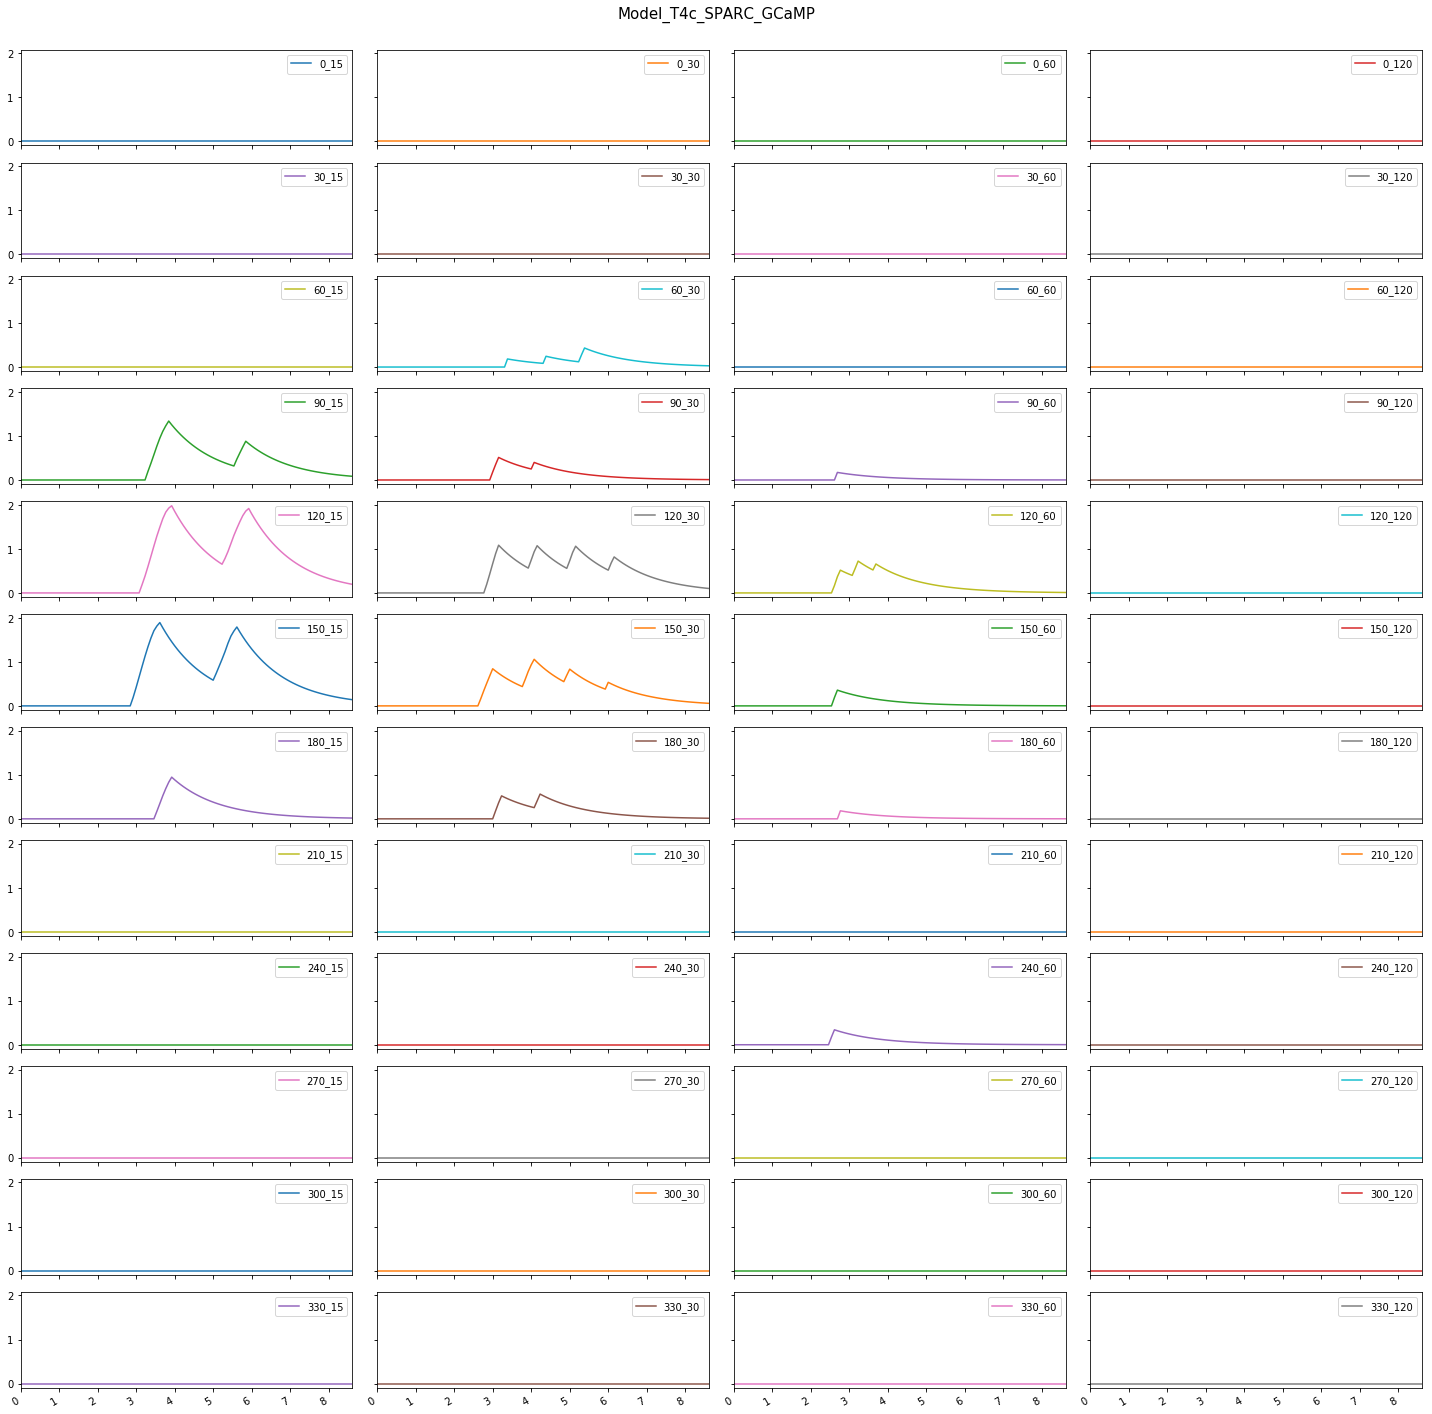

In [15]:
plot_data(df_model, title='Model_T4c_SPARC_GCaMP')

In [21]:
sti = '330_30'
arclight = data_Arclight[sti]
gcamp = data_Gcamp[sti]
gcamp_model = pd.Series(Ca_model(np.array(data_Arclight[sti]), tau=1.68, dt=0.07689999999999997,
                 thres=0.00, gain=53.33))

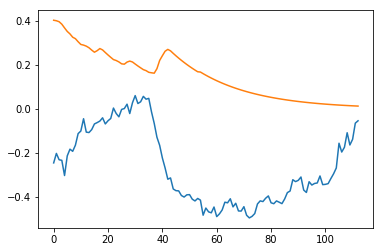

In [22]:
plt.plot(gcamp)
plt.plot(gcamp_model);

In [23]:
shift_signal_peak(gcamp_model, gcamp, 20.0), shift_signal_correlate(gcamp_model, gcamp)

(12, 112)

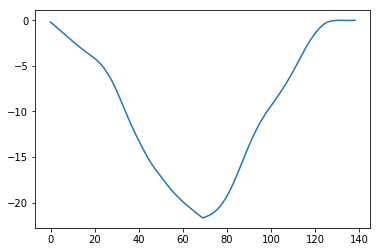

In [15]:
plt.plot(signal.correlate(gcamp_model[20:90], gcamp[20:90]));

In [16]:
np.argmax(signal.correlate(gcamp_model, gcamp)) - (len(gcamp_model) - 1)

112

In [17]:
np.argmax(gcamp_model), np.argmax(gcamp)

(52, 27)

In [96]:
len(gcamp_model) - 1

112

In [97]:
len(gcamp)

113

In [98]:
len(gcamp_model)

113

In [84]:
from scipy import signal, fftpack
import numpy
a = numpy.array([0, 1, 2, 3, 4, 3, 2, 1, 0, 1, 2, 3, 4, 3, 2, 1, 0, 0, 0, 0, 0])
b = numpy.array([0, 0, 0, 0, 0, 1, 2, 3, 4, 3, 2, 1, 0, 1, 2, 3, 4, 3, 2, 1, 0])
numpy.argmax(signal.correlate(a,b))
numpy.argmax(signal.correlate(b,a)) 

24

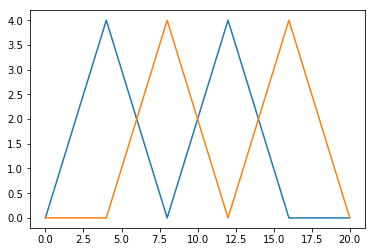

In [85]:
plt.plot(a)
plt.plot(b);

In [87]:
len(a) - 1

20